In [23]:
# General-purpose libraries for data manipulation, numerical operations, and visualization
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Scikit-learn: Utilities for data preprocessing, evaluation metrics, and splitting datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc, 
    f1_score, 
    mean_squared_error, 
    mean_absolute_error, 
    roc_auc_score
)

# PyTorch: Deep learning framework for building and training neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

# Transformers library: Pretrained models and tools for natural language processing
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel, pipeline

# tqdm: Progress bar library for monitoring loops (e.g., training and evaluation)
from tqdm import tqdm


In [3]:
# Open and read the JSON file
with open('/Users/mayankgrover/Documents/AIT726/Project/btc_train.json', 'r') as file:
  dataBTC = json.load(file)

with open('/Users/mayankgrover/Documents/AIT726/Project/eth_train.json', 'r') as file:
  dataETH = json.load(file)

In [4]:
def createDF(dataBTC):
    """
    Converts nested data containing dates, prices, and news with optional sentiment 
    into a flattened DataFrame for analysis.

    Args:
        dataBTC (dict): Dictionary with keys as dates, and values as dictionaries containing
                        'prices' and a list of 'news'.

    Returns:
        pd.DataFrame: Flattened DataFrame with columns ['date', 'price', 'news', 'sentiment'].
    """
    rows = []

    # Iterate through each date and its corresponding details
    for date, details in dataBTC.items():
        price = details['prices']  # Get the price for the date
        news_list = details['news']  # Get the list of news articles

        # Iterate through each news item for the given date
        for news in news_list:
            if "(sentiment:" in news:
                # Extract the news text and sentiment if sentiment is present
                news_text, sentiment = news.rsplit(" (sentiment:", 1)
                sentiment = sentiment.rstrip(')')  # Remove trailing parenthesis from sentiment
            else:
                # If no sentiment is present, default to None
                news_text = news
                sentiment = None

            # Append the flattened data to the rows list
            rows.append({
                'date': date,
                'price': price,
                'news': news_text.strip(),  # Strip leading/trailing whitespace
                'sentiment': sentiment.strip() if sentiment else None  # Handle None sentiment
            })

    # Create a DataFrame from the rows list
    df = pd.DataFrame(rows)

    return df


In [5]:
# Create DataFrames for Bitcoin and Ethereum from nested data structures
BTC_df = createDF(dataBTC)
ETH_df = createDF(dataETH)

In [6]:
# Add a 'currency' column to indicate Bitcoin (BTC) and Ethereum (ETH)
BTC_df['currency'] = 'BTC'
ETH_df['currency'] = 'ETC'

In [7]:
# Combine BTC and ETH dataframes, shuffle the rows, and reset the index
df = pd.concat([BTC_df, ETH_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,date,price,news,sentiment,currency
0,2023-02-14,22220.804144,another 'strong' crypto bull run may lie ahead...,positive,ETC
1,2023-02-28,23147.353390,wrapped bitcoin supply drops to negative after...,negative,ETC
2,2023-03-03,22362.679332,dollar's sharp recovery puts bitcoin's $25k br...,negative,ETC
3,2023-03-07,22219.769071,hong kong's losses to crypto scams doubled to ...,negative,ETC
4,2023-03-02,23475.466738,3 btc price hurdles bitcoin bulls are failing ...,negative,BTC


In [9]:
# Map sentiment strings to numerical labels
labels = {'positive': 2, 'neutral': 1, 'negative': 0}
df['sentiment_label'] = df['sentiment'].map(labels)

In [10]:
# printing the value counts of sentiment_label
df['sentiment_label'].value_counts()

2    582
0    274
1    270
Name: sentiment_label, dtype: int64

In [11]:
# checking for null values
df['sentiment_label'].isnull().value_counts()

False    1126
Name: sentiment_label, dtype: int64

In [12]:
from sklearn.utils import resample

# Separate each class into separate DataFrames
df_class_0 = df[df['sentiment_label'] == 0]
df_class_1 = df[df['sentiment_label'] == 1]
df_class_2 = df[df['sentiment_label'] == 2]

print(len(df_class_0), len(df_class_1), len(df_class_2))
# Find the class with the maximum number of samples
max_samples = max(len(df_class_0), len(df_class_1), len(df_class_2))

# Oversample minority classes to match the largest class
df_class_0_oversampled = resample(df_class_0, replace=True, n_samples=max_samples, random_state=42)
df_class_1_oversampled = resample(df_class_1, replace=True, n_samples=max_samples, random_state=42)
df_class_2_oversampled = df_class_2

# Combine all oversampled classes
balanced_df = pd.concat([df_class_0_oversampled, df_class_1_oversampled, df_class_2_oversampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Verify the class distribution
print(balanced_df['sentiment_label'].value_counts())


274 270 582
0    582
1    582
2    582
Name: sentiment_label, dtype: int64


In [13]:
# Dataset class for multi-task learning, handling both sentiment and price prediction tasks
class MultiTaskDataset(Dataset):
    def __init__(self, df, tokenizer):
        # Initialize the dataset with text, sentiment labels, and price labels
        self.texts = df['news'].tolist()  # List of news text
        self.sentiment_labels = df['sentiment_label'].tolist()  # Sentiment labels
        self.price_labels = df['price'].tolist()  # Price labels
        self.tokenizer = tokenizer  # Tokenizer for text preprocessing

    def __len__(self):
        # Return the length of the dataset
        return len(self.texts)

    def __getitem__(self, idx):
        # Get a specific item by index
        text = self.texts[idx]  # News text
        sentiment_label = self.sentiment_labels[idx]  # Sentiment label
        price_label = self.price_labels[idx]  # Price label

        # Tokenize the text using the tokenizer, with padding and truncation
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        # Squeeze to remove unnecessary dimensions
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        
        # Add sentiment and price labels to the encoding
        encoding['sentiment_label'] = torch.tensor(sentiment_label, dtype=torch.long)
        encoding['price'] = torch.tensor(price_label, dtype=torch.float)
        
        # Return the final encoded 
        return encoding

In [14]:
# importing the tokenizer from FinBert model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# defining the scaler
scaler = MinMaxScaler()

# Fit only on training data
train_df['price'] = scaler.fit_transform(train_df[['price']])

# Transform testing data
test_df['price'] = scaler.transform(test_df[['price']])


# Convert the train and test DataFrames into MultiTaskDataset objects
train_df = MultiTaskDataset(train_df, tokenizer)  # Prepare the training dataset
test_df = MultiTaskDataset(test_df, tokenizer)    # Prepare the testing dataset

In [15]:
class MultiTaskModel(nn.Module):
    def __init__(self, sentiment_model_name='ProsusAI/finbert', price_model_name='bert-base-uncased', num_classes_sentiment=3):
        super(MultiTaskModel, self).__init__()
        
        # Sentiment model (FinBERT)
        self.sentiment_model = BertModel.from_pretrained(sentiment_model_name)  # Pre-trained FinBERT model
        self.sentiment_head = nn.Linear(self.sentiment_model.config.hidden_size, num_classes_sentiment)  # Sentiment classification head
        
        # Price prediction model (using a general BERT for regression)
        self.price_model = BertModel.from_pretrained(price_model_name)  # Pre-trained BERT model for price prediction
        self.price_head = nn.Linear(self.price_model.config.hidden_size, 1)  # Regression task for price prediction

    def forward(self, input_ids, attention_mask):
        # Sentiment task: Pass through the sentiment model to get sentiment logits
        sentiment_outputs = self.sentiment_model(input_ids=input_ids, attention_mask=attention_mask)
        sentiment_pooled_output = sentiment_outputs.pooler_output  # [CLS] token representation
        sentiment_logits = self.sentiment_head(sentiment_pooled_output)  # Apply the sentiment classification head
        
        # Price prediction task: Pass through the price model to get price prediction
        price_outputs = self.price_model(input_ids=input_ids, attention_mask=attention_mask)
        price_pooled_output = price_outputs.pooler_output  # [CLS] token representation
        price_prediction = self.price_head(price_pooled_output)  # Apply the price regression head
        
        return sentiment_logits, price_prediction  # Return both sentiment logits and price prediction


In [16]:
def compute_loss(sentiment_logits, sentiment_labels, price_predictions, price_labels, alpha=0.5):
    # Sentiment Loss (Classification)
    sentiment_loss = F.cross_entropy(sentiment_logits, sentiment_labels)  # Cross-entropy loss for sentiment classification
    
    # Price Loss (Regression)
    price_loss = F.mse_loss(price_predictions.squeeze(), price_labels)  # Mean Squared Error loss for price regression
    
    # Weighted sum of both losses using alpha to balance the importance of each task
    total_loss = alpha * sentiment_loss + (1 - alpha) * price_loss
    return total_loss  # Return the combined total loss


In [17]:
class CryptoDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        # Initialize the dataset with the provided dataframe, tokenizer, and max length for tokenization
        self.texts = df['news'].values  # Extract the 'news' column
        self.sentiment_labels = df['sentiment_label'].values  # Extract the sentiment labels
        self.max_length = max_length  # Set the maximum length for tokenization
        self.tokenizer = tokenizer  # The tokenizer for encoding the texts

    def __len__(self):
        # Return the length of the dataset (number of texts)
        return len(self.texts)

    def __getitem__(self, idx):
        # Get the text and sentiment label for the given index
        text = self.texts[idx]
        sentiment_label = self.sentiment_labels[idx]
        
        # Tokenize the text with padding, truncation, and conversion to tensors
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add [CLS] and [SEP] tokens
            max_length=self.max_length,  # Max length for padding/truncation
            padding='max_length',  # Pad sequences to the maximum length
            truncation=True,  # Truncate if sequence exceeds max length
            return_tensors='pt'  # Return PyTorch tensors
        )
        
        # Return the tokenized inputs and sentiment label
        return {
            'input_ids': encoding['input_ids'].squeeze(),  # Remove extra dimension
            'attention_mask': encoding['attention_mask'].squeeze(),  # Remove extra dimension
            'sentiment_label': torch.tensor(sentiment_label, dtype=torch.long)  # Convert sentiment label to tensor
        }


In [18]:
def train_model_multi_task(model, train_loader, device, epochs, learning_rate, alpha):
    # Initialize the optimizer and loss functions for sentiment classification and price regression
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion_sentiment = nn.CrossEntropyLoss()  # Loss for sentiment classification
    criterion_price = nn.MSELoss()  # Loss for price regression

    epoch_losses = []  # List to store the total loss for each epoch

    # Loop through the epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Initialize running loss for the current epoch

        # Loop through the training data in batches
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            # Load batch data and move to device (GPU/CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiment_label = batch['sentiment_label'].to(device)
            price = batch['price'].to(device)

            # Zero the gradients of the optimizer
            optimizer.zero_grad()

            # Perform forward pass through the model
            sentiment_logits, price_prediction = model(input_ids, attention_mask)

            # Compute losses for both tasks
            sentiment_loss = criterion_sentiment(sentiment_logits, sentiment_label)  # Sentiment loss
            price_loss = criterion_price(price_prediction.squeeze(-1), price)  # Price loss
            combined_loss = alpha * sentiment_loss + (1 - alpha) * price_loss  # Weighted sum of the two losses

            # Backpropagate the combined loss
            combined_loss.backward()
            optimizer.step()  # Update model parameters

            running_loss += combined_loss.item()  # Add the loss for this batch to running total

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)  # Store the average loss for the epoch

        # Print the epoch loss
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

    # Plot the training loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [25]:
from torch.utils.data import DataLoader

# Create DataLoader for training and testing datasets
train_loader = DataLoader(train_df, batch_size=32, shuffle=True)
test_loader = DataLoader(test_df, batch_size=32, shuffle=True)

# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)

# Call the train method
train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=3,              
    learning_rate=2e-5,    
    alpha=0.5              
)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expe

Epoch 1, Loss: 21.7893


Epoch 2/3: 100%|████████████████████████████████| 44/44 [22:45<00:00, 31.03s/it]


Epoch 2, Loss: 9.8927


Epoch 3/3: 100%|████████████████████████████████| 44/44 [19:23<00:00, 26.45s/it]


Epoch 3, Loss: 3.3127


In [21]:
def evaluate_model1(model, test_loader, device):
    model.eval()
    all_preds_sentiment = []
    all_labels_sentiment = []
    all_probs_sentiment = []  # To store probabilities for ROC AUC
    all_preds_price = []
    all_labels_price = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiment_labels = batch['sentiment_label'].to(device)
            price_labels = batch['price'].to(device)

            # Model inference
            sentiment_logits, price_predictions = model(input_ids, attention_mask)
            sentiment_probs = torch.softmax(sentiment_logits, dim=-1)  # Convert logits to probabilities
            sentiment_preds = torch.argmax(sentiment_logits, dim=-1)

            # Collect predictions and labels for sentiment
            all_preds_sentiment.extend(sentiment_preds.cpu().numpy())
            all_labels_sentiment.extend(sentiment_labels.cpu().numpy())
            all_probs_sentiment.extend(sentiment_probs.cpu().numpy())  # Collect probabilities for ROC AUC

            # Collect predictions and labels for price
            all_preds_price.extend(price_predictions.cpu().numpy())
            all_labels_price.extend(price_labels.cpu().numpy())

    # Sentiment Accuracy
    sentiment_accuracy = (np.array(all_preds_sentiment) == np.array(all_labels_sentiment)).mean()
    print(f'Sentiment Accuracy: {sentiment_accuracy * 100:.2f}%')

    # Sentiment Confusion Matrix
    cm = confusion_matrix(all_labels_sentiment, all_preds_sentiment)
    print("Sentiment Confusion Matrix:")
    print(cm)

    # Sentiment F1 Score
    f1 = f1_score(all_labels_sentiment, all_preds_sentiment, average='weighted')
    print(f'F1 Score (Sentiment): {f1:.2f}')

    # ROC AUC (Sentiment)
    all_labels_sentiment = np.array(all_labels_sentiment)
    all_probs_sentiment = np.array(all_probs_sentiment)
    num_classes = all_probs_sentiment.shape[1]

    # One-vs-all ROC AUC calculation
    if num_classes > 2:  # Multiclass ROC AUC
        roc_auc = roc_auc_score(all_labels_sentiment, all_probs_sentiment, multi_class='ovr', average='weighted')
        print(f'Weighted ROC AUC (Sentiment): {roc_auc:.2f}')

        # Plot ROC Curves for each class
        plt.figure(figsize=(10, 6))
        for class_idx in range(num_classes):
            fpr, tpr, _ = roc_curve(all_labels_sentiment == class_idx, all_probs_sentiment[:, class_idx])
            plt.plot(fpr, tpr, label=f"Class {class_idx} (AUC = {auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC AUC Curve (Sentiment)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Price prediction MSE
    price_mse = np.mean((np.array(all_preds_price).flatten() - np.array(all_labels_price)) ** 2)
    print(f'Mean Squared Error (Price Prediction): {price_mse:.4f}')


Sentiment Accuracy: 96.29%
Sentiment Confusion Matrix:
[[126   2   2]
 [  0  93   5]
 [  0   4 118]]
F1 Score (Sentiment): 0.96
Weighted ROC AUC (Sentiment): 0.99


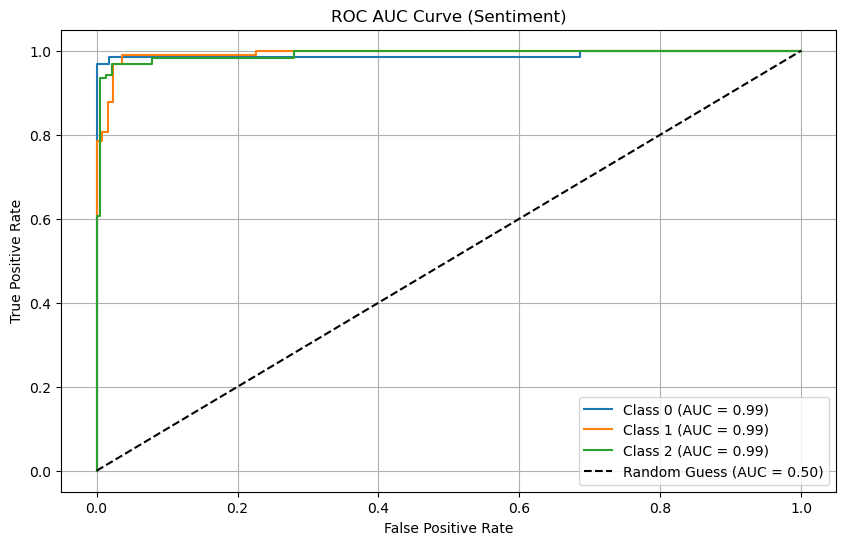

Mean Squared Error (Price Prediction): 0.0244


In [104]:
evaluate_model1(model, test_loader, device)


In [105]:
def predict_sentiment_and_price(model, tokenizer, custom_text, device, scaler):
    # Tokenize the input text
    encoding = tokenizer(custom_text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
    
    # Move all tensors to the correct device (GPU or CPU)
    encoding = {key: val.to(device) for key, val in encoding.items()}
    
    # Removing 'token_type_ids' 
    if 'token_type_ids' in encoding:
        del encoding['token_type_ids']
    
    # Model evaluation
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        outputs = model(**encoding)
        
        # Print outputs to check structure
        print("Model Outputs:", outputs)
        
        # Access outputs by index if they are returned as a tuple
        sentiment_logits = outputs[0]  # Adjust this index as needed
        price_pred = outputs[1]  # Adjust this index as needed
    
    # Get sentiment prediction
    sentiment_pred = torch.argmax(sentiment_logits, dim=1).item()

    # Convert price prediction (scaled) to original price
    price_pred_scaled = price_pred.item()
    price_pred_original = scaler.inverse_transform([[price_pred_scaled]])[0][0]
    

    # Sentiment mapping (adjust based on your specific sentiment labels)
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment = sentiment_mapping.get(sentiment_pred, "Unknown")

    return sentiment, price_pred_original



# Demonstration

In [108]:
# news
custom_text = 'Etherium Set to Cross $100,000 on Post-Election Rally'
# Get the predicted scaled price from the model
sentiment, price = predict_sentiment_and_price(model, tokenizer, custom_text, device, scaler)
predicted_price = price.item()


# Print the results
print(f"Predicted Sentiment: {sentiment}")
print(f"Predicted Price (Original Scale): ${predicted_price}")


Model Outputs: (tensor([[-2.1657, -1.0367,  3.1759]]), tensor([[0.7067]]))
Predicted Sentiment: Positive
Predicted Price (Original Scale): $26046.801737268066


### Fine tuning

In [109]:
train_loader = DataLoader(train_df, batch_size=32, shuffle=True)
test_loader = DataLoader(test_df, batch_size=32, shuffle=True)

# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)

train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=5,              
    learning_rate=2e-5,    
    alpha=0.5              
)

Epoch 1/5: 100%|████████████████████████████████| 44/44 [24:53<00:00, 33.95s/it]


Epoch 1, Loss: 1.0519


Epoch 2/5: 100%|██████████████████████████████| 44/44 [1:00:55<00:00, 83.07s/it]


Epoch 2, Loss: 0.6163


Epoch 3/5: 100%|████████████████████████████████| 44/44 [18:50<00:00, 25.70s/it]


Epoch 3, Loss: 0.4257


Epoch 4/5: 100%|█████████████████████████████| 44/44 [2:30:05<00:00, 204.66s/it]


Epoch 4, Loss: 0.2937


Epoch 5/5: 100%|████████████████████████████████| 44/44 [16:08<00:00, 22.01s/it]

Epoch 5, Loss: 0.4609


Sentiment Accuracy: 96.29%
Sentiment Confusion Matrix:
[[126   2   2]
 [  0  95   3]
 [  0   6 116]]
F1 Score (Sentiment): 0.96
Weighted ROC AUC (Sentiment): 0.99


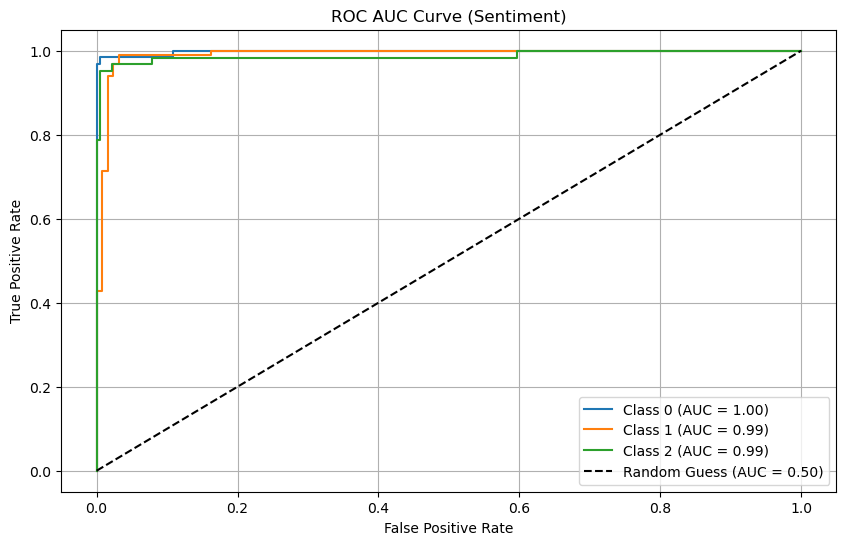

Mean Squared Error (Price Prediction): 0.0160


In [110]:
# evaluate model
evaluate_model1(model, test_loader, device)

In [111]:
train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
test_loader = DataLoader(test_df, batch_size=64, shuffle=True)

# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)

train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=3,              
    learning_rate=2e-5,    
    alpha=0.5              
)

Epoch 1/3: 100%|████████████████████████████████| 22/22 [19:47<00:00, 53.99s/it]


Epoch 1, Loss: 0.0857


Epoch 2/3: 100%|████████████████████████████████| 22/22 [21:22<00:00, 58.29s/it]


Epoch 2, Loss: 0.0563


Epoch 3/3: 100%|████████████████████████████████| 22/22 [22:21<00:00, 61.00s/it]

Epoch 3, Loss: 0.0431


Sentiment Accuracy: 96.29%
Sentiment Confusion Matrix:
[[126   2   2]
 [  0  95   3]
 [  0   6 116]]
F1 Score (Sentiment): 0.96
Weighted ROC AUC (Sentiment): 0.99


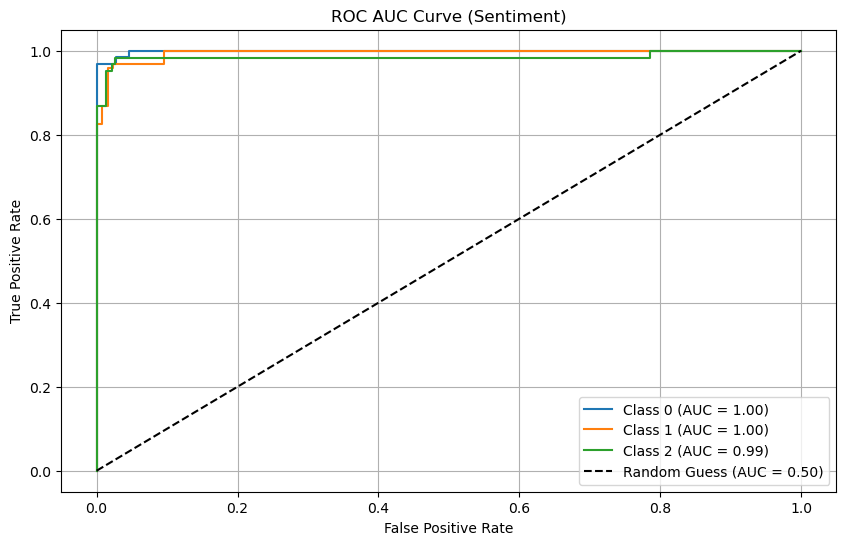

Mean Squared Error (Price Prediction): 0.0142


In [112]:
# evaluate model
evaluate_model1(model, test_loader, device)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expe

Epoch 1, Loss: 0.5417


Epoch 2/5: 100%|████████████████████████████████| 22/22 [19:18<00:00, 52.67s/it]


Epoch 2, Loss: 0.3230


Epoch 3/5: 100%|████████████████████████████████| 22/22 [20:52<00:00, 56.93s/it]


Epoch 3, Loss: 0.1306


Epoch 4/5: 100%|████████████████████████████████| 22/22 [20:22<00:00, 55.59s/it]


Epoch 4, Loss: 0.0417


Epoch 5/5: 100%|████████████████████████████████| 22/22 [21:01<00:00, 57.34s/it]


Epoch 5, Loss: 0.0188


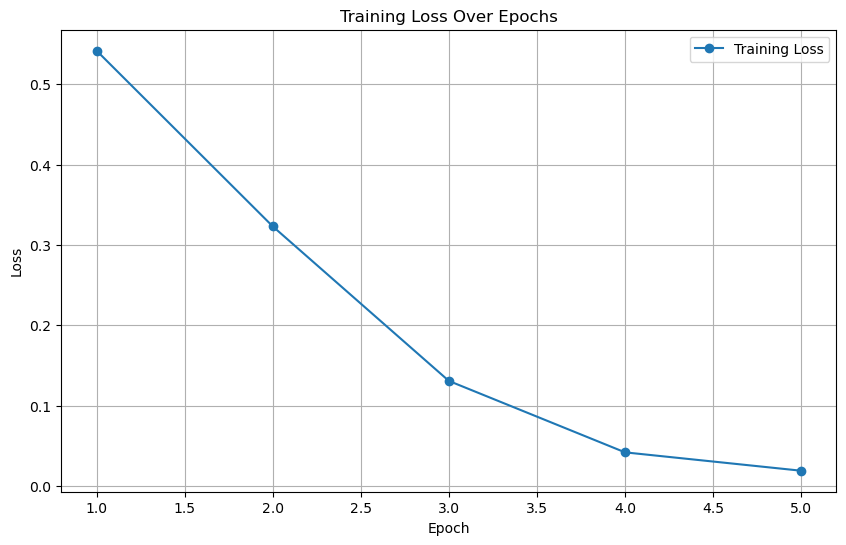

In [115]:
train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
test_loader = DataLoader(test_df, batch_size=64, shuffle=True)
model = MultiTaskModel().to(device)

# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)

train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=5,              
    learning_rate=2e-5,    
    alpha=0.5              
)

Sentiment Accuracy: 97.14%
Sentiment Confusion Matrix:
[[128   2   0]
 [  1  96   1]
 [  2   4 116]]
F1 Score (Sentiment): 0.97
Weighted ROC AUC (Sentiment): 0.99


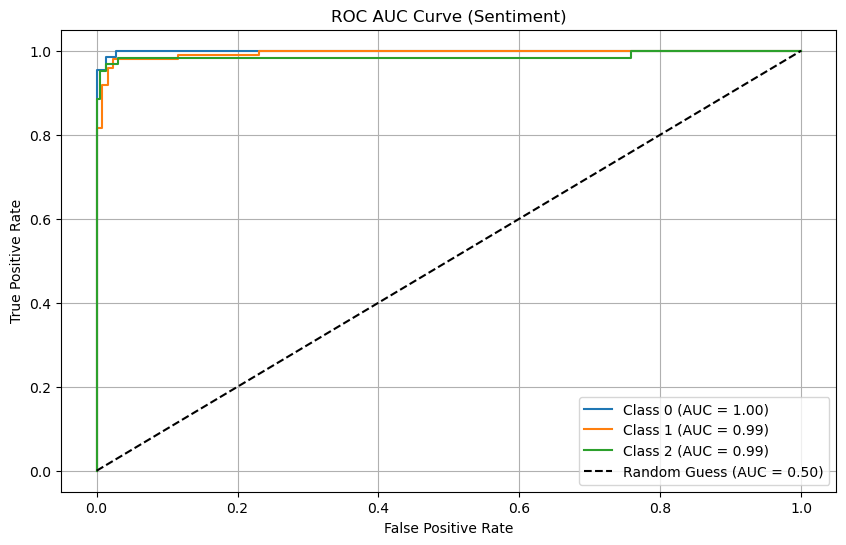

Mean Squared Error (Price Prediction): 0.0211


In [116]:
# evaluate model
evaluate_model1(model, test_loader, device)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expe

Epoch 1, Loss: 0.3954


Epoch 2/3: 100%|████████████████████████████████| 88/88 [20:03<00:00, 13.68s/it]


Epoch 2, Loss: 0.1141


Epoch 3/3: 100%|████████████████████████████████| 88/88 [21:59<00:00, 14.99s/it]


Epoch 3, Loss: 0.0296


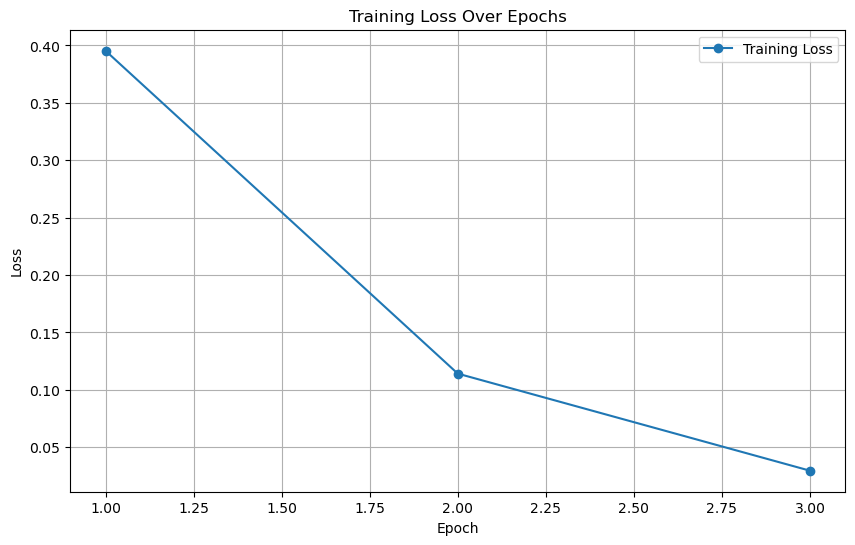

In [19]:
train_loader = DataLoader(train_df, batch_size=16, shuffle=True)
test_loader = DataLoader(test_df, batch_size=16, shuffle=True)

# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)

train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=3,              
    learning_rate=2e-5,    
    alpha=0.5              
)

Sentiment Accuracy: 99.14%
Sentiment Confusion Matrix:
[[130   0   0]
 [  0  96   2]
 [  0   1 121]]
F1 Score (Sentiment): 0.99
Weighted ROC AUC (Sentiment): 1.00


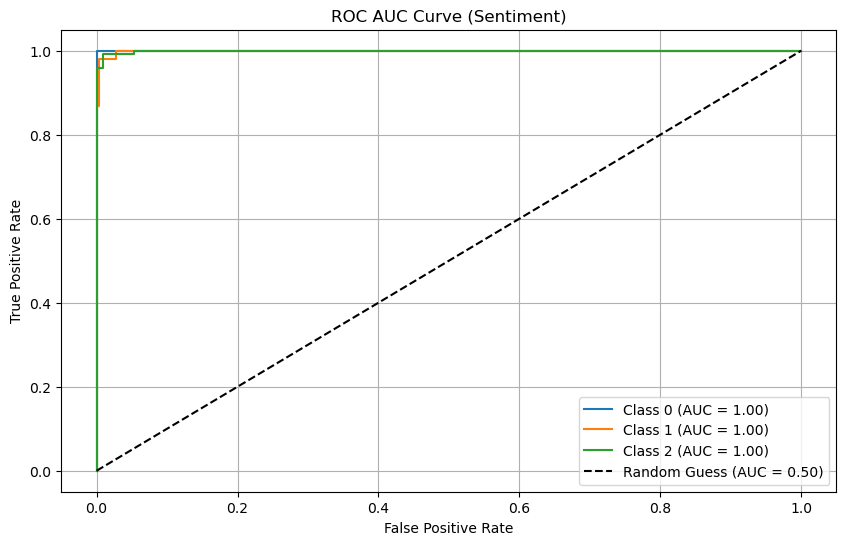

Mean Squared Error (Price Prediction): 0.0193


In [24]:
# evaluate model
evaluate_model1(model, test_loader, device)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expe

Epoch 1, Loss: 0.3820


Epoch 2/5: 100%|████████████████████████████████| 88/88 [14:21<00:00,  9.79s/it]


Epoch 2, Loss: 0.1155


Epoch 3/5: 100%|████████████████████████████████| 88/88 [17:20<00:00, 11.82s/it]


Epoch 3, Loss: 0.0272


Epoch 4/5: 100%|██████████████████████████████| 88/88 [1:13:30<00:00, 50.12s/it]


Epoch 4, Loss: 0.0144


Epoch 5/5: 100%|██████████████████████████████| 88/88 [1:22:23<00:00, 56.18s/it]


Epoch 5, Loss: 0.0189


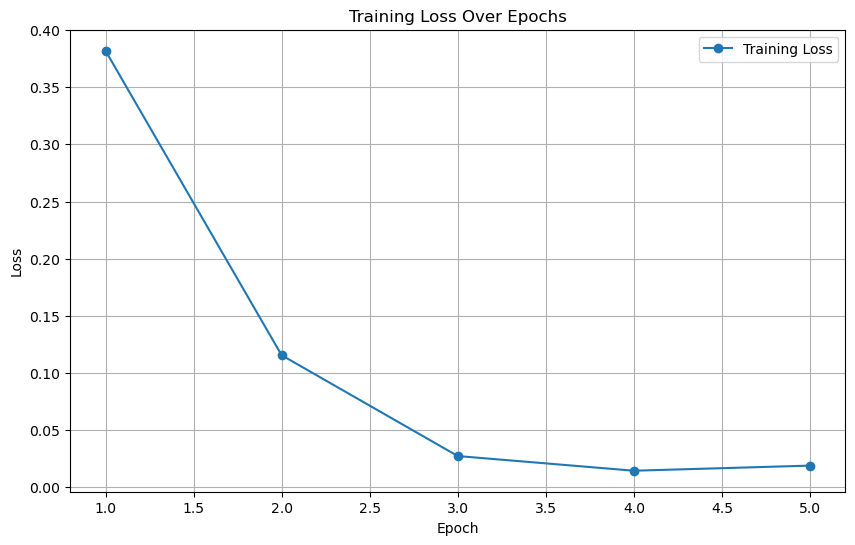

In [25]:
train_loader = DataLoader(train_df, batch_size=16, shuffle=True)
test_loader = DataLoader(test_df, batch_size=16, shuffle=True)
# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)
# Call the train method
train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=5,              
    learning_rate=2e-5,    
    alpha=0.5              
)

Sentiment Accuracy: 99.14%
Sentiment Confusion Matrix:
[[129   0   1]
 [  0  96   2]
 [  0   0 122]]
F1 Score (Sentiment): 0.99
Weighted ROC AUC (Sentiment): 1.00


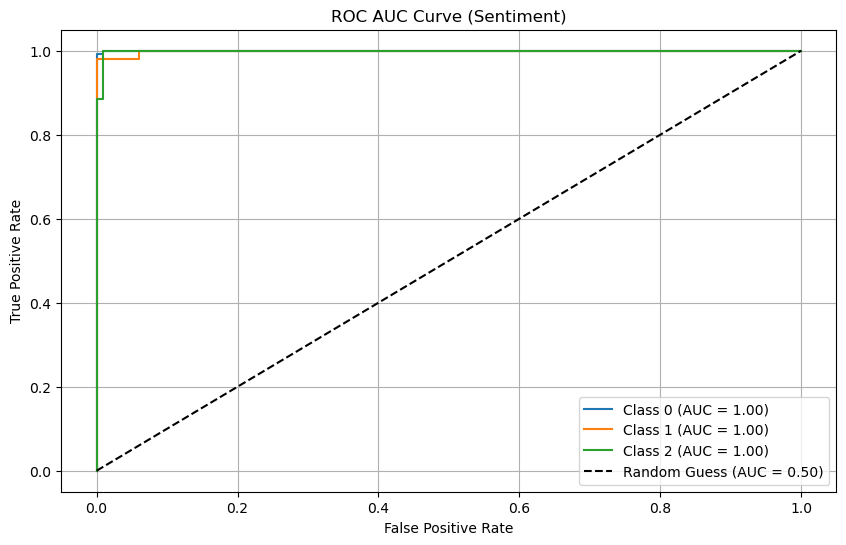

Mean Squared Error (Price Prediction): 0.0134


In [26]:
# evaluate model
evaluate_model1(model, test_loader, device)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expe

Epoch 1, Loss: 0.6464


Epoch 2/3: 100%|████████████████████████████████| 22/22 [23:11<00:00, 63.25s/it]


Epoch 2, Loss: 0.5710


Epoch 3/3: 100%|███████████████████████████████| 22/22 [55:22<00:00, 151.02s/it]


Epoch 3, Loss: 0.4590


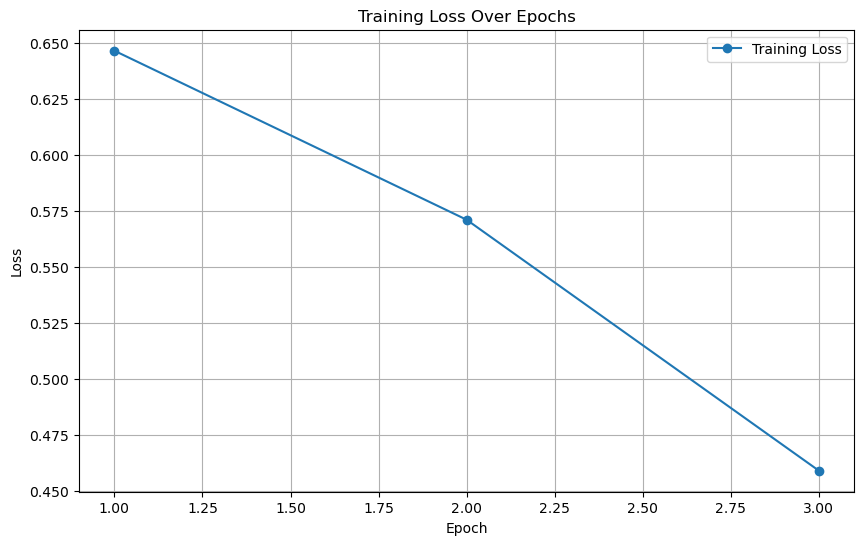

In [27]:
train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
test_loader = DataLoader(test_df, batch_size=64, shuffle=True)
# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)
# Calling train method
train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=3,              
    learning_rate=2e-4,    
    alpha=0.5              
)

Sentiment Accuracy: 79.14%
Sentiment Confusion Matrix:
[[114   4  12]
 [  0  82  16]
 [ 25  16  81]]
F1 Score (Sentiment): 0.79
Weighted ROC AUC (Sentiment): 0.92


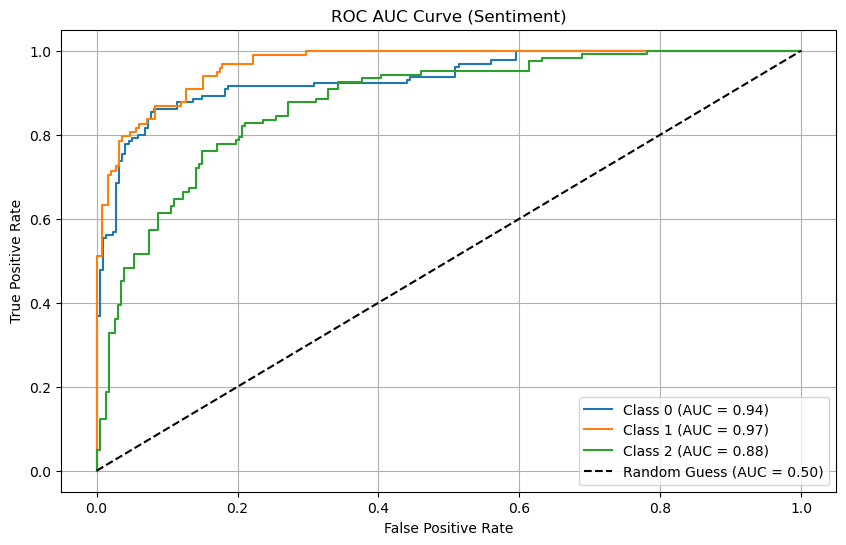

Mean Squared Error (Price Prediction): 0.0920


In [28]:
# evaluate model
evaluate_model1(model, test_loader, device)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expe

Epoch 1, Loss: 0.5382


Epoch 2/3: 100%|████████████████████████████████| 22/22 [26:36<00:00, 72.57s/it]


Epoch 2, Loss: 0.3756


Epoch 3/3: 100%|███████████████████████████████| 22/22 [39:35<00:00, 107.97s/it]


Epoch 3, Loss: 0.2395


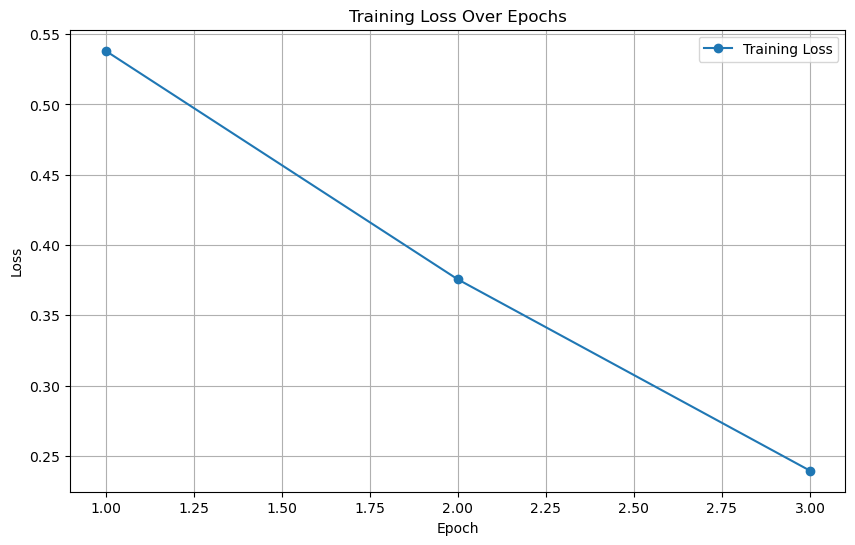

In [29]:
train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
test_loader = DataLoader(test_df, batch_size=64, shuffle=True)
# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)

train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=3,              
    learning_rate=1e-5,    
    alpha=0.5              
)

Sentiment Accuracy: 92.86%
Sentiment Confusion Matrix:
[[125   4   1]
 [  3  88   7]
 [  1   9 112]]
F1 Score (Sentiment): 0.93
Weighted ROC AUC (Sentiment): 0.99


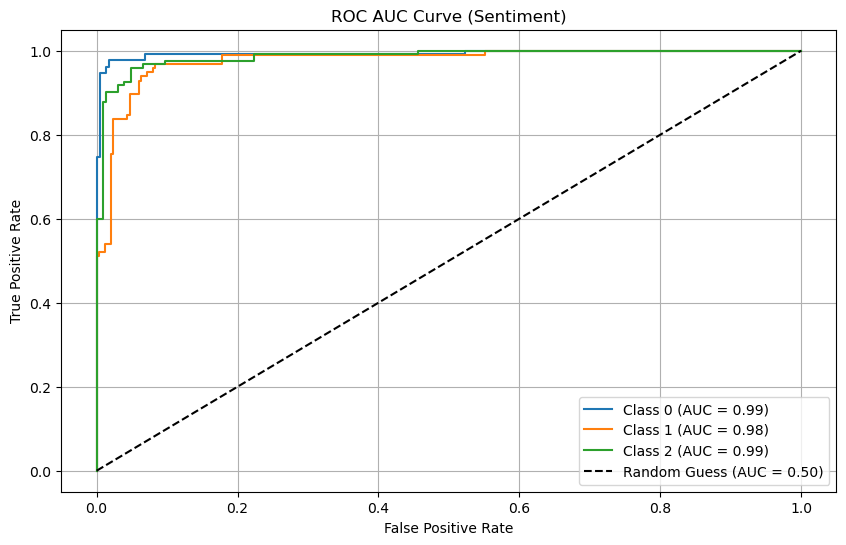

Mean Squared Error (Price Prediction): 0.0685


In [30]:
# evaluate model
evaluate_model1(model, test_loader, device)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expe

Epoch 1, Loss: 0.6362


Epoch 2/5: 100%|████████████████████████████████| 22/22 [27:20<00:00, 74.56s/it]


Epoch 2, Loss: 0.3715


Epoch 3/5: 100%|████████████████████████████████| 22/22 [27:22<00:00, 74.66s/it]


Epoch 3, Loss: 0.2493


Epoch 4/5: 100%|████████████████████████████████| 22/22 [28:19<00:00, 77.27s/it]


Epoch 4, Loss: 0.1624


Epoch 5/5: 100%|████████████████████████████████| 22/22 [25:56<00:00, 70.76s/it]


Epoch 5, Loss: 0.1090


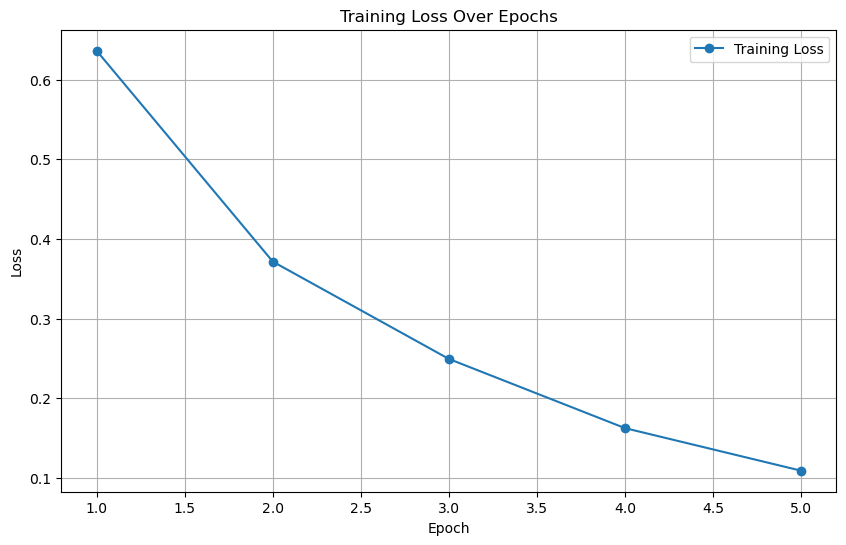

In [31]:
train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
test_loader = DataLoader(test_df, batch_size=64, shuffle=True)
# Initialize the model and move it to the GPU
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)
train_model_multi_task(
    model=model,           
    train_loader=train_loader,  
    device=device,         
    epochs=5,              
    learning_rate=1e-5,    
    alpha=0.5              
)

Sentiment Accuracy: 97.14%
Sentiment Confusion Matrix:
[[128   2   0]
 [  0  91   7]
 [  0   1 121]]
F1 Score (Sentiment): 0.97
Weighted ROC AUC (Sentiment): 1.00


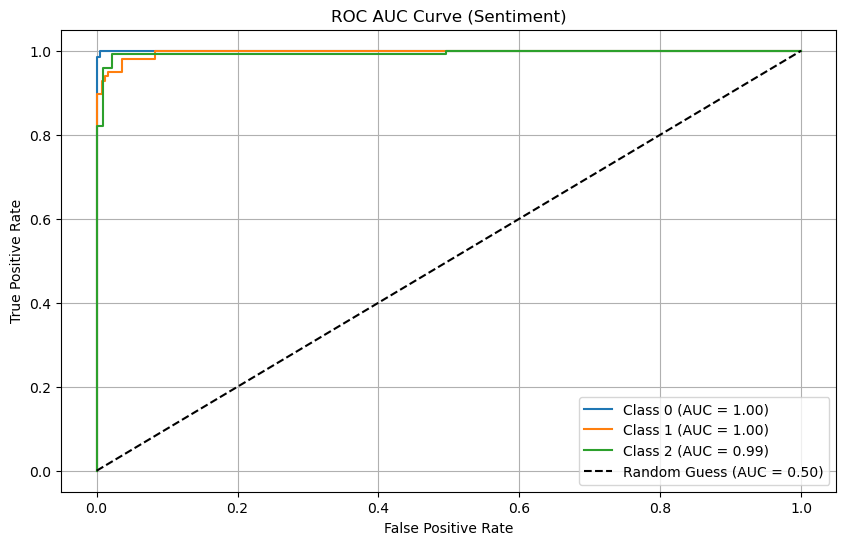

Mean Squared Error (Price Prediction): 0.0649


In [32]:
# evaluate model
evaluate_model1(model, test_loader, device)